# This is the classifier for the butterfly dataset

Below there is the machine learning workflow pipeline

Import packages and device selection

In [231]:
import os
import cv2
from PIL import Image
from collections import Counter
import optuna
from optuna.trial import TrialState
from tqdm.notebook import tqdm
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, Subset
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [232]:
path = '../data/images'
pixels_per_side = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [233]:
print("Using device: ", device)

Using device:  cuda


## Dataset loading and preprocessing

In [234]:
data = []
labels = []
folder = os.listdir(path)
for file in folder:
    img = cv2.imread(str(os.path.join(path, file)))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (pixels_per_side, pixels_per_side))
    data.append(img)
    labels.append(int(file[:3]) - 1)
# labels = np.array(labels)
classes = ['Danaus plexippus', 'Heliconius charitonius', 'Heliconius erato', 'Junonia coenia', 'Lycaena phlaeas',
           'Nymphalis antiopa', 'Papilio cresphontes', 'Pieris rapae', 'Vanessa atalanta', 'Vanessa cardui']

In [235]:
print([classes[labels[i]] for i in range(10)])

['Lycaena phlaeas', 'Vanessa cardui', 'Vanessa cardui', 'Junonia coenia', 'Lycaena phlaeas', 'Nymphalis antiopa', 'Papilio cresphontes', 'Danaus plexippus', 'Pieris rapae', 'Nymphalis antiopa']


Display some samples

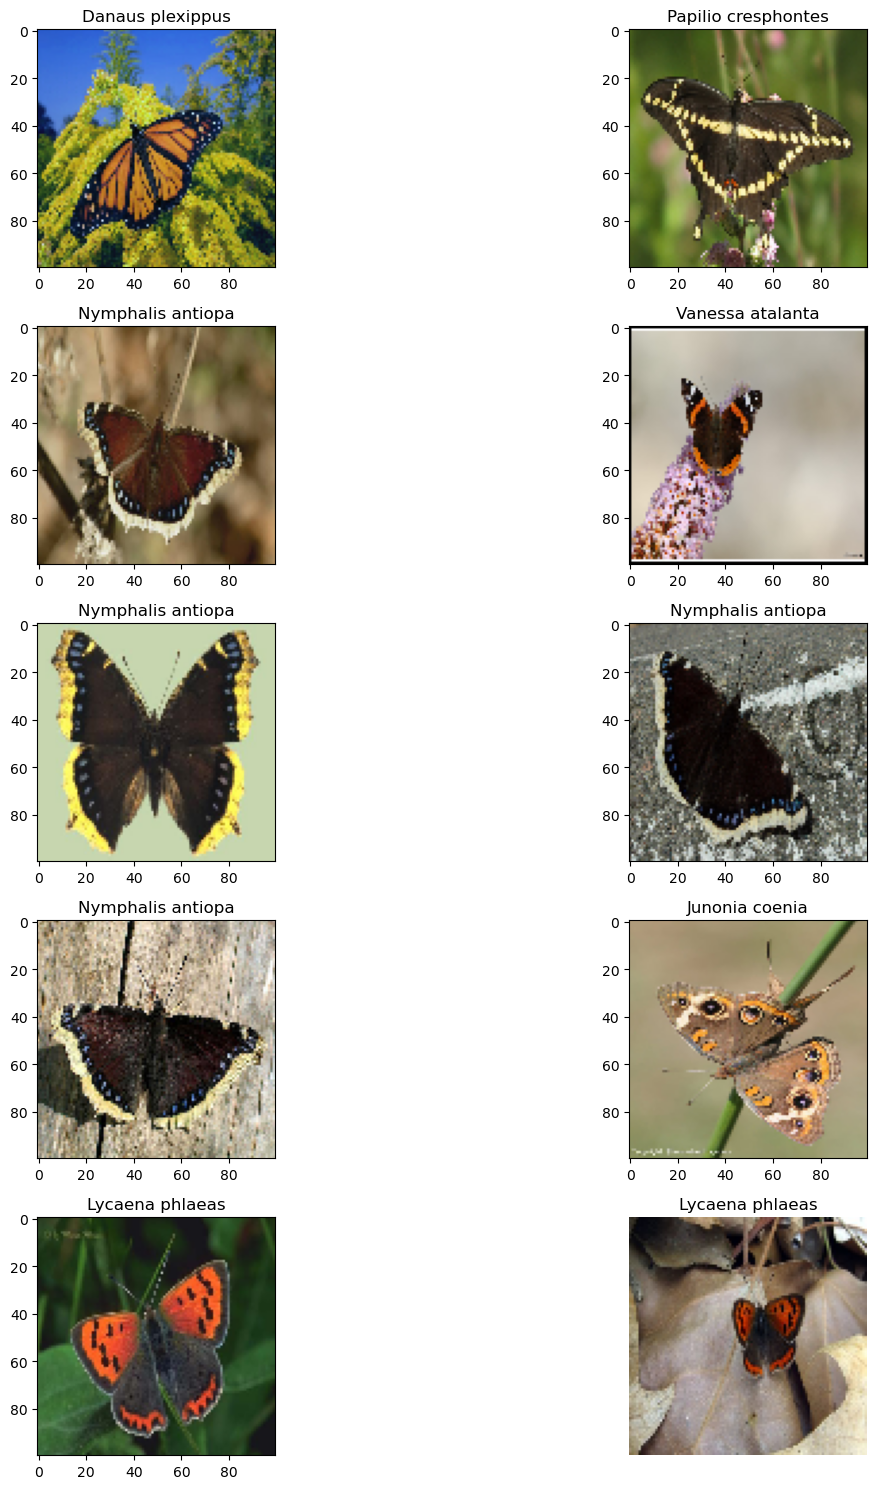

In [236]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=np.random.randint(0,len(labels))
        ax[i,j].imshow(data[l])
        ax[i,j].set_title(str(classes[labels[l]]))
plt.axis('off')        
plt.tight_layout()

Display dataset distribution

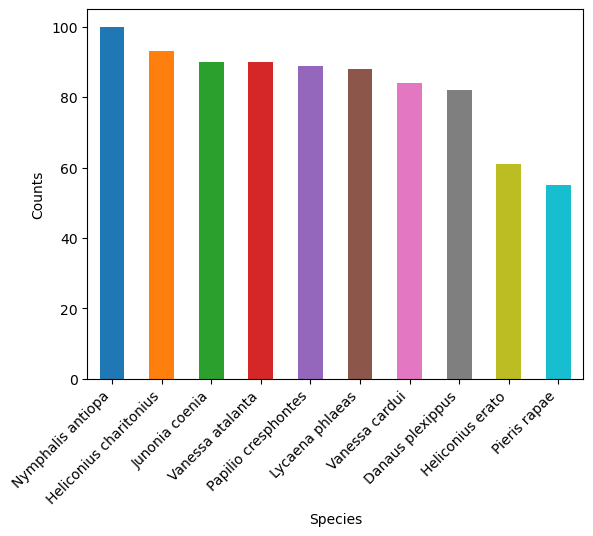

In [237]:
df = pd.DataFrame(labels, columns=['labels'])
df['labels'] = [classes[i] for i in df['labels']]
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = [cycle[i % len(cycle)] for i in range(len(df['labels'].unique()))]
df['labels'].value_counts().plot(kind='bar', color=colors)
plt.xlabel('Species')
plt.ylabel('Counts')
plt.xticks(rotation=45, ha='right')
plt.show()

In [238]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data[idx]
        data = Image.fromarray(data, mode='RGB')
        if self.transform:
            data = self.transform(data)
        labels = torch.tensor(self.labels[idx])
        return data, labels

In [239]:
dataset = MyDataset(data, labels, transform=transforms.ToTensor())
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)
total_sum = torch.zeros(3)
total_squared_sum = torch.zeros(3)
total_count = 0
for images, _ in dataloader:
    total_sum += images.sum(dim=[0, 2, 3])
    total_squared_sum += (images ** 2).sum(dim=[0, 2, 3])
    total_count += images.numel() / images.shape[1]
mean = total_sum / total_count
std = torch.sqrt((total_squared_sum / total_sum) - (mean ** 2))
mean = mean.tolist()
std = std.tolist()

In [240]:
print(mean, std)

[0.4617842733860016, 0.4470069408416748, 0.3209322690963745] [0.6528047919273376, 0.6390608549118042, 0.6760880351066589]


In [241]:
data = np.array(data)
labels = np.array(labels)
print(data.shape, labels.shape)
print(data)
print(labels)

(832, 100, 100, 3) (832,)
[[[[ 57 134   0]
   [ 72 140  26]
   [ 79 143  58]
   ...
   [117 167  40]
   [116 153  47]
   [132 155  84]]

  [[ 71 136  24]
   [ 69 136   3]
   [ 76 142  45]
   ...
   [118 164  32]
   [119 158  53]
   [107 145  65]]

  [[100 145  75]
   [ 82 140  27]
   [ 70 138  23]
   ...
   [114 160  28]
   [111 155  56]
   [ 95 151  64]]

  ...

  [[109 179  29]
   [111 185  47]
   [112 194  42]
   ...
   [101 117  54]
   [111 111  57]
   [104 115  59]]

  [[112 187  46]
   [113 187  50]
   [117 190  53]
   ...
   [111 120  65]
   [105 130  63]
   [ 94 130  66]]

  [[120 193  63]
   [113 194  46]
   [116 195  49]
   ...
   [ 98 128  49]
   [ 89 131  45]
   [ 74 126  38]]]


 [[[ 57  85  72]
   [ 65  91  78]
   [ 70  92  81]
   ...
   [ 46  53  46]
   [ 46  53  46]
   [ 46  53  46]]

  [[ 78 106  92]
   [ 47  73  60]
   [ 81 102  90]
   ...
   [ 46  53  46]
   [ 46  53  46]
   [ 46  53  46]]

  [[ 72 100  86]
   [ 61  87  74]
   [ 51  74  61]
   ...
   [ 46  53  46]
  

Data agumentation

In [228]:
# TODO: fix data augmentation portion
class_counts = Counter(labels)
target_count = 100
samples_needed = {cls: target_count - count for cls, count in class_counts.items()}
aug_data = []
aug_labels = []

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
])

In [230]:
print(len(data), len(labels))
print(type(data), type(labels))
print(type(data[0]), type(labels[0]))
print(data[0].shape)

832 832
<class 'list'> <class 'list'>
<class 'numpy.ndarray'> <class 'int'>
(100, 100, 3)


In [ ]:
dataset = MyDataset(data, labels, transform=transforms.ToTensor())
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)
for img, label in zip(data, labels):
    if samples_needed[label] > 0:
        for _ in range(samples_needed[label]):
            augmented_img = transform(img)
            aug_data.append(augmented_img)
            aug_labels.append(label)
        samples_needed[label] = 0  # Reset to 0 after reaching the target
data.extend(aug_data)
labels.extend(aug_labels)

## Training pipeline

Split into training data and test data

In [214]:
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
dataset = MyDataset(data, labels, transform=trans)
trainset, testset = random_split(dataset, [0.9, 0.1])

CNN definition

In [215]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 5)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(10, 25, 5)
        self.conv3 = nn.Conv2d(25, 16, 5)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(16 * 18 * 18, 64) # ((100 -4)/2 -4)/2 -4
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.flat(x)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5)
        x = self.fc2(x)
        return x

Train and validate methods

In [216]:
def fit(net, trainloader, optimizer, loss_fn=nn.CrossEntropyLoss()):
    net.train()
    total_loss, acc, count = 0, 0, 0
    for features, labels in trainloader:
        features = features.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        out = net(features)
        loss = loss_fn(out, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss
        _, predicted = torch.max(out, 1)
        acc += (predicted == labels).sum()
        count += len(labels)
    return total_loss.item() / count, acc.item() / count

def predict(net, valloader, loss_fn=nn.CrossEntropyLoss()):
    net.eval()
    count, acc, total_loss = 0, 0, 0
    with torch.no_grad():
        for features, labels in valloader:
            features = features.to(device)
            labels = labels.to(device)
            count += len(labels)
            out = net(features)
            total_loss += loss_fn(out, labels)
            pred = torch.max(out, 1)[1]
            acc += (pred == labels).sum()
    return total_loss.item() / count, acc.item() / count

Objective method for k fold cross validation

In [217]:
def objective(trial, trainset, X, y):
    lr = trial.suggest_float('lr', 0.001, 0.1, log=True)
    batch_size = trial.suggest_categorical('batch_size', [64, 128, 256])
    epochs = trial.suggest_int('epochs', 30, 80)
    net = Net().to(device)
    optimizer = optim.Adam(net.parameters(), lr=lr)

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    val_accs = []
    train_acc, train_loss, val_acc, val_loss, mean_acc = 0, 0, 0, 0, 0
    split_num = 0
    prog_bar = tqdm(skf.split(X, y), desc="Splits")
    for train_index, val_index in prog_bar:
        split_num += 1
        train_data = Subset(trainset, train_index)
        val_data = Subset(trainset, val_index)
        trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        valloader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

        for epoch in range(epochs):
            train_loss, train_acc = fit(net, trainloader, optimizer)
            val_loss, val_acc = predict(net, valloader)
            prog_bar.set_description(
                f"Split {split_num} - Epoch {epoch + 1}, Train acc={train_acc:.3f}, Train loss={train_loss:.3f}, "
                f"Test acc={val_acc:.3f}, Test loss={val_loss:.3f}")

        val_accs.append(val_acc)
        mean_acc = np.mean(val_accs)
        trial.report(mean_acc, split_num)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    return mean_acc

In [218]:
X = np.zeros(len(trainset))
labelloader =  DataLoader(trainset, batch_size=128, shuffle=False)
y = []
for _, label in labelloader:
    y.append(label.numpy())
y = np.concatenate(y, axis=0)
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
study.optimize(lambda trial: objective(trial, trainset, X, y), n_trials=10)

[I 2024-09-04 17:26:04,559] A new study created in memory with name: no-name-7dd49f0f-f15f-4e68-9fa1-66e68701948c


Splits: 0it [00:00, ?it/s]

[W 2024-09-04 17:26:06,749] Trial 0 failed with parameters: {'lr': 0.0012020727497667443, 'batch_size': 256, 'epochs': 55} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/vito/miniconda3/envs/pyatom/lib/python3.11/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_10309/2247630428.py", line 8, in <lambda>
    study.optimize(lambda trial: objective(trial, trainset, X, y), n_trials=10)
                                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_10309/1391314999.py", line 21, in objective
    train_loss, train_acc = fit(net, trainloader, optimizer)
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_10309/2336541834.py", line 4, in fit
    for features, labels in trainloader:
  File "/home/vito/miniconda3/envs/pyatom/lib/python3.11/site-packages/torch/utils/data/dataloade

KeyboardInterrupt: 

In [ ]:
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

start tensorboard to further visualization of the CNN

In [ ]:
writer = SummaryWriter("../runs")
net = Net().to(device)
writer.add_graph(net, torch.zeros((1, 3, pixels_per_side, pixels_per_side)).to(device))
writer.flush()
summary(net, input_size=(1, 3, pixels_per_side, pixels_per_side))

In [ ]:
trainloader = DataLoader(trainset, batch_size=trial.params['batch_size'], shuffle=True)
testloader = DataLoader(testset, batch_size=trial.params['batch_size'], shuffle=False)
optimizer = optim.Adam(net.parameters(), lr=trial.params['lr'])
train_accs, train_losses, test_accs, test_losses = [], [], [], []
prog_bar = tqdm(range(trial.params['epochs']), total=trial.params['epochs'])
for epoch in prog_bar:
    train_loss, train_acc = fit(net,trainloader, optimizer)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_loss, test_acc = predict(net, testloader)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    prog_bar.set_description(f"Epoch {epoch + 1}, Train acc={train_acc:.3f}, Train loss={train_loss:.3f}, "
                             f"Test acc={test_acc:.3f}, Test loss={test_loss:.3f}")

## Evaulate results

In [ ]:
train_accs = np.array(train_accs)
train_losses = np.array(train_losses)
test_accs = np.array(test_accs)
test_losses = np.array(test_losses)
print(train_losses.shape, test_losses.shape)
print(train_losses, test_losses)
print(train_accs.shape, test_accs.shape)
print(train_accs, test_accs)

In [ ]:
plt.figure()
plt.plot(train_accs, label='Train acc')
plt.plot(test_accs, label='Test acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

plt.figure()
plt.plot(train_losses, label='Train loss')
plt.plot(test_losses, label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(bottom=0)
plt.legend()
plt.show()